<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/kfold-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Fold Cross Validation and Bootstrap Estimation
(Fayyaz Minhas)

## Comparing $K$-fold Cross-Validation to Repeated i.i.d. Testing

This section provides a practical way to *visualise and reason about* the bias and variance of different **performance estimators**, rather than of the classifier itself. In particular, we contrast stratified $K$-fold cross-validation against **repeated i.i.d. testing**, which we use as a Monte Carlo proxy for the *actual test performance* under the same data-generating distribution.

The key idea is that, because we control the data generator, we can simulate what would normally be inaccessible in real applications: repeated draws from the true test distribution. This allows us to separate estimator bias from estimator variance in a concrete and intuitive way.

---

## 1. Data-generating process and fixed training set

We assume access to a generator that produces i.i.d. samples $(x,y)$ with $y \in \{+1,-1\}$. The positive class occurs with probability $\pi$, and the negative class is multimodal. From this generator we draw a *single* realised training dataset

$$
\mathcal{D}_{\text{train}} = \{(x_i,y_i)\}_{i=1}^n,
$$

with fixed size $n$. All subsequent evaluations condition on this realised dataset.

Let

$$
n_{+} = \sum_{i=1}^n \mathbf{1}(y_i = +1), \qquad
n_{-} = \sum_{i=1}^n \mathbf{1}(y_i = -1)
$$

denote the class counts in the training set.

---

## 2. Stratified $K$-fold cross-validation as an estimator

For each $K$ in a specified range, we perform stratified $K$-fold cross-validation with multiple random shuffles. Stratification ensures that class proportions are preserved across folds, but imposes the constraint

$$
K \le \min(n_{+}, n_{-}),
$$

which is enforced automatically to avoid degenerate folds.

For each repetition $r=1,\dots,R$ and each fold $j=1,\dots,K$, we train a model $f_{K}^{(r,j)}$ on the training split and compute a fold-level AUROC on the validation split:

$$
\widehat{\mathrm{AUROC}}_{K}^{(r,j)}
=
\mathrm{AUROC}\bigl(s_{K}^{(r,j)}(X_{\text{val}}^{(r,j)}),\, y_{\text{val}}^{(r,j)}\bigr),
$$

where $s(\cdot)$ denotes the real-valued ranking score (here the SVM decision function).

For each $K$, we collect all fold-level AUROCs across folds and repetitions into a distribution

$$
\mathcal{A}_K
=
\{\widehat{\mathrm{AUROC}}_{K}^{(r,j)}\}.
$$

This distribution reflects both:
- **estimator variance** due to finite validation folds and random splits, and
- **estimator bias** arising from the reduced effective training size $(1 - 1/K)n$ used in each fold.

---

## 3. Training the final model on all available data

To mirror real-world deployment, we train a single final model on the entire training dataset:

$$
f_{\text{full}} \leftarrow \text{Train}(\mathcal{D}_{\text{train}}).
$$

This is the model whose generalisation performance we ultimately care about.

---

## 4. Repeated i.i.d. testing as a Monte Carlo proxy for true test performance

In practice, the true test distribution is unknown and only one test set is available. Here, because we have access to the data generator, we can *simulate* repeated test datasets drawn from the same distribution:

$$
\mathcal{D}_{\text{test}}^{(t)} = \{(x_i^{(t)}, y_i^{(t)})\}_{i=1}^m,
\qquad t = 1,\dots,T.
$$

We evaluate the *same fixed model* $f_{\text{full}}$ on each test set:

$$
\widehat{\mathrm{AUROC}}_{\text{test}}^{(t)}
=
\mathrm{AUROC}\bigl(s_{\text{full}}(X_{\text{test}}^{(t)}),\, y_{\text{test}}^{(t)}\bigr).
$$

The repeated-test estimator is then summarised by

$$
\mu_{\text{test}} = \frac{1}{T}\sum_{t=1}^T \widehat{\mathrm{AUROC}}_{\text{test}}^{(t)},
\qquad
\sigma_{\text{test}}^2 = \mathrm{Var}\bigl(\widehat{\mathrm{AUROC}}_{\text{test}}^{(t)}\bigr).
$$

Because each $\mathcal{D}_{\text{test}}^{(t)}$ is an independent draw from the same distribution, $\mu_{\text{test}}$ is an approximately unbiased Monte Carlo estimate of the *true generalisation AUROC* of $f_{\text{full}}$, while $\sigma_{\text{test}}^2$ quantifies the irreducible variability due to finite test sampling.

In simulation settings, this plays the role of a surrogate ground truth against which other estimators can be compared.

---

## 5. Visual comparison: CV estimates versus repeated-test reference

To compare estimators, we plot:

- boxplots of $\mathcal{A}_K$ for each $K$ (distribution of fold-level CV AUROCs),
- a red line showing $\mathrm{median}(\mathcal{A}_K)$,
- a horizontal dashed line at $\mu_{\text{test}}$,
- a shaded band corresponding to $\mu_{\text{test}} \pm \sigma_{\text{test}}$.

This visualisation allows direct comparison between:
- the *distribution* of CV-based estimates at each $K$, and
- the repeated-test estimate of true generalisation performance.

---

## 6. Bias and variance of the estimators

It is important to emphasise that we are analysing the **bias–variance trade-off of performance estimators**, not of the classifier.

### Bias

- For small $K$, each CV model is trained on a substantially reduced dataset, leading to pessimistic estimates when the learning curve has not saturated.
- As $K$ increases, the training fraction approaches $1$, reducing bias relative to $\mu_{\text{test}}$.

### Variance

- For large $K$, validation folds become small, especially under class imbalance.
- AUROC estimates computed on small folds exhibit high variance, resulting in wide boxplots and unstable medians.

Repeated testing, by contrast, has:
- low bias (fresh samples from the true distribution),
- low variance (large test sets and averaging over repetitions),
but relies on access to the data generator or an effectively unlimited test source.

---

## Key takeaway

Repeated i.i.d. testing provides a principled Monte Carlo approximation to true test performance under the same distribution, making it an invaluable reference in simulation studies. By comparing stratified $K$-fold CV estimates across $K$ to this reference, we can directly observe how estimator bias decreases and estimator variance increases as $K$ grows—particularly in imbalanced settings where $K$ is inherently constrained by the minority class size.


Generator: DataStreamGenerator(pos_ratio=0.2, d=2, random_seed=42)
Training set: (200, 2) Pos: 47 Neg: 153

Per-K median fold AUROC:
  K= 2  median_fold_AUROC=0.6467  (n_fold_scores=40)
  K= 4  median_fold_AUROC=0.6759  (n_fold_scores=80)
  K= 6  median_fold_AUROC=0.6568  (n_fold_scores=120)
  K= 8  median_fold_AUROC=0.6667  (n_fold_scores=160)
  K=10  median_fold_AUROC=0.6982  (n_fold_scores=200)
  K=12  median_fold_AUROC=0.6923  (n_fold_scores=240)
  K=14  median_fold_AUROC=0.6970  (n_fold_scores=280)
  K=16  median_fold_AUROC=0.7000  (n_fold_scores=320)
  K=18  median_fold_AUROC=0.7083  (n_fold_scores=360)
  K=20  median_fold_AUROC=0.6875  (n_fold_scores=400)
  K=22  median_fold_AUROC=0.6429  (n_fold_scores=440)
  K=24  median_fold_AUROC=0.7143  (n_fold_scores=480)
  K=26  median_fold_AUROC=0.6833  (n_fold_scores=520)
  K=28  median_fold_AUROC=0.7000  (n_fold_scores=560)
  K=30  median_fold_AUROC=0.7000  (n_fold_scores=600)
  K=32  median_fold_AUROC=0.7500  (n_fold_scores=640)
  K=3

/tmp/ipython-input-3192004587.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=ks, showmeans=True)


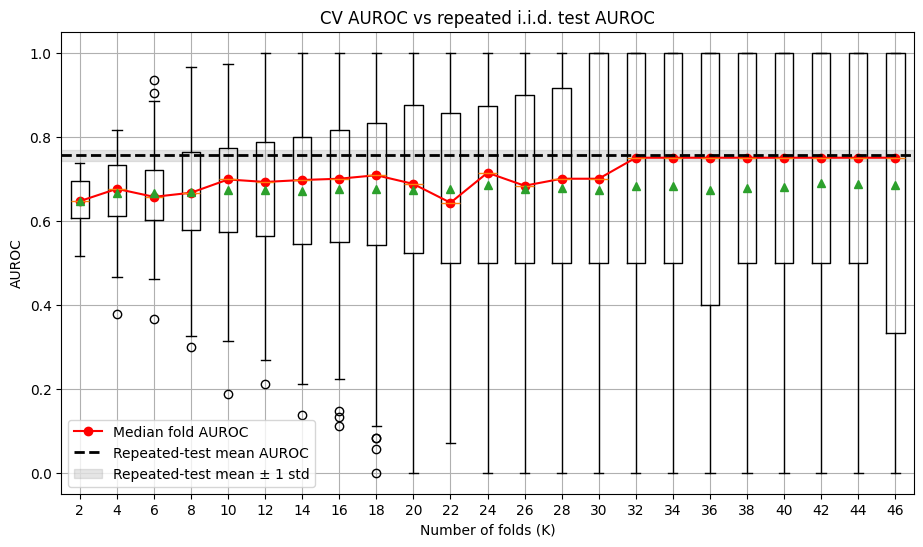

In [1]:
# Complete code that:
# 1) generates training data
# 2) sweeps K for Stratified K-fold CV AUROC (repeated runs)
# 3) ALSO estimates "true" generalisation AUROC via repeated fresh i.i.d. test sets
#    and plots that as a horizontal reference band/line against the CV boxplots
# 4) trains final model on full training set (once)
#
# Notes:
# - Uses decision_function for AUROC (no probability=True needed)
# - Caps max K automatically based on minority class count to avoid StratifiedKFold errors
# - Plots:
#   * Boxplots of fold-level AUROCs for each K (across folds and runs)
#   * Red line: median fold AUROC per K
#   * Black dashed line: mean repeated-test AUROC (proxy for "true" performance)
#   * Grey band: ±1 std of repeated-test AUROC across runs

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score


# -----------------------------
# Data generator
# -----------------------------
class DataStreamGenerator:
    """
    Produces one example at a time with a fixed proportion of positives.
    y in {+1, -1}
    """
    def __init__(self, pos_ratio=0.5, d=2, random_seed=None):
        assert 0 <= pos_ratio <= 1, "pos_ratio must be between 0 and 1."
        self.pos_ratio = pos_ratio
        self.d = d
        self.random_seed = random_seed
        if random_seed is not None:
            np.random.seed(random_seed)

    def generate_example(self):
        if np.random.rand() < self.pos_ratio:
            x = randn(self.d) + 1
            y = +1
        else:
            # negative mixture of two clusters
            if np.random.rand() < 0.5:
                x = randn(self.d) - 1
            else:
                x = randn(self.d) + 2
            y = -1
        return x, y

    def generate_batch(self, n):
        X, Y = [], []
        for _ in range(n):
            x, y = self.generate_example()
            X.append(x)
            Y.append(y)
        return np.asarray(X), np.asarray(Y)

    def __repr__(self):
        return f"DataStreamGenerator(pos_ratio={self.pos_ratio}, d={self.d}, random_seed={self.random_seed})"


# -----------------------------
# CV evaluation over K
# -----------------------------
def evaluate_kfold_auroc_svm(X, y, max_k=50, skip=2, num_runs=20,
                            C=10.0, gamma=1.0, kernel="rbf"):
    """
    Returns:
      all_fold_aurocs: dict[k] = list of AUROCs (all folds across all runs)
    """
    y = np.asarray(y)

    n_pos = int(np.sum(y == 1))
    n_neg = int(np.sum(y == -1))
    max_k_allowed = min(n_pos, n_neg)
    if max_k_allowed < 2:
        raise ValueError(f"Not enough samples for 2-fold CV. n_pos={n_pos}, n_neg={n_neg}")

    max_k = int(min(max_k, max_k_allowed))

    all_fold_aurocs = {}
    for k in range(2, max_k + 1, skip):
        fold_aurocs = []
        for run in range(num_runs):
            skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42 + run)
            for tr_idx, va_idx in skf.split(X, y):
                model = SVC(C=C, kernel=kernel, gamma=gamma)  # probability=False
                model.fit(X[tr_idx], y[tr_idx])
                scores = model.decision_function(X[va_idx])
                fold_aurocs.append(roc_auc_score(y[va_idx], scores))
        all_fold_aurocs[k] = fold_aurocs

    return all_fold_aurocs


# -----------------------------
# Repeated i.i.d. test evaluation
# -----------------------------
def repeated_test_auroc(generator, model, test_size=2000, num_runs=20):
    """
    Estimates generalisation AUROC by evaluating the SAME trained model
    on multiple fresh i.i.d. test sets drawn from the generator.
    """
    aurocs = []
    for _ in range(num_runs):
        X_test, y_test = generator.generate_batch(test_size)
        scores = model.decision_function(X_test)
        aurocs.append(roc_auc_score(y_test, scores))
    return np.asarray(aurocs)


# -----------------------------
# Plot: CV vs repeated-test reference
# -----------------------------
def plot_cv_vs_test(all_fold_aurocs, test_aurocs,
                    title="CV AUROC vs repeated i.i.d. test AUROC",
                    band="std"):
    """
    band: "std" for ±1 std, or "ci95" for empirical 2.5/97.5 percentiles
    """
    ks = sorted(all_fold_aurocs.keys())
    data = [all_fold_aurocs[k] for k in ks]
    medians = [np.nanmedian(all_fold_aurocs[k]) for k in ks]

    test_mean = float(np.mean(test_aurocs))

    if band == "std":
        test_lo = float(test_mean - np.std(test_aurocs, ddof=1))
        test_hi = float(test_mean + np.std(test_aurocs, ddof=1))
        band_label = "Repeated-test mean ± 1 std"
    elif band == "ci95":
        test_lo = float(np.quantile(test_aurocs, 0.025))
        test_hi = float(np.quantile(test_aurocs, 0.975))
        band_label = "Repeated-test 95% empirical interval"
    else:
        raise ValueError("band must be 'std' or 'ci95'")

    plt.figure(figsize=(11, 6))
    plt.boxplot(data, labels=ks, showmeans=True)

    # Median fold AUROC per K
    plt.plot(range(1, len(ks) + 1), medians, marker='o', linestyle='-', color='red', label='Median fold AUROC')

    # Repeated-test reference line and band
    plt.axhline(test_mean, color='black', linestyle='--', linewidth=2, label='Repeated-test mean AUROC')
    plt.axhspan(test_lo, test_hi, color='gray', alpha=0.2, label=band_label)

    plt.title(title)
    plt.xlabel("Number of folds (K)")
    plt.ylabel("AUROC")
    plt.grid(True)
    plt.legend()
    plt.show()


# -----------------------------
# Main script
# -----------------------------
if __name__ == "__main__":
    # Settings (match your intent)
    pos_ratio = 0.2
    d = 2
    seed = 42

    n_train = 200
    max_k = 50
    skip = 2
    num_runs_cv = 20

    C = 10.0
    gamma = 1.0
    kernel = "rbf"

    # Repeated-test settings
    test_size = 2000
    num_runs_test = 20

    # 1) Generate training data
    generator = DataStreamGenerator(pos_ratio=pos_ratio, d=d, random_seed=seed)
    X_train, y_train = generator.generate_batch(n_train)

    print("Generator:", generator)
    print("Training set:", X_train.shape, "Pos:", np.sum(y_train == 1), "Neg:", np.sum(y_train == -1))

    # 2) Sweep K for CV AUROC
    all_fold_aurocs = evaluate_kfold_auroc_svm(
        X_train, y_train, max_k=max_k, skip=skip, num_runs=num_runs_cv,
        C=C, gamma=gamma, kernel=kernel
    )

    # Print per-K summary (median fold AUROC)
    print("\nPer-K median fold AUROC:")
    for k in sorted(all_fold_aurocs.keys()):
        print(f"  K={k:2d}  median_fold_AUROC={np.nanmedian(all_fold_aurocs[k]):.4f}  "
              f"(n_fold_scores={len(all_fold_aurocs[k])})")

    # 3) Train a final model once (as in your original code)
    final_model = SVC(C=C, kernel=kernel, gamma=gamma)
    final_model.fit(X_train, y_train)

    # 4) Repeated i.i.d. test AUROC for "true" performance proxy
    test_aurocs = repeated_test_auroc(
        generator, final_model, test_size=test_size, num_runs=num_runs_test
    )

    print(f"\nRepeated i.i.d. test AUROC over {num_runs_test} runs (test_size={test_size}):")
    print(f"  Mean: {np.mean(test_aurocs):.4f}")
    print(f"  Std : {np.std(test_aurocs, ddof=1):.4f}")
    print(f"  Min/Max: {np.min(test_aurocs):.4f} / {np.max(test_aurocs):.4f}")

    # 5) Plot CV distributions vs repeated-test reference
    plot_cv_vs_test(all_fold_aurocs, test_aurocs, band="std")


## Estimating Generalisation Performance with Bootstrap

In this section we examine how different performance estimators behave for the *same classifier* under a controlled data-generating process. Although cross-validation and bootstrap methods are often treated as interchangeable estimates of generalisation performance, they in fact answer subtly different questions and can exhibit systematic bias.

---

## Experimental setup

We consider a binary classification problem generated from a known distribution, with class imbalance and nonlinear structure. A single RBF SVM classifier is trained on a fixed training dataset of size $n$, and all evaluation methods are applied to this same realised dataset.

Because the data-generating process is known, we can repeatedly draw fresh i.i.d. test samples. This allows us to construct a Monte Carlo estimate of the true generalisation performance of the trained model.

---

## Repeated test AUROC: a Monte Carlo reference

We first train a final model $f_{\text{full}}$ on the entire training set. We then evaluate this fixed model on multiple independently generated test sets:

$$
\widehat{\mathrm{AUROC}}_{\text{test}}^{(r)}
=
\mathrm{AUROC}\bigl(f_{\text{full}}(X_{\text{test}}^{(r)}),\, y_{\text{test}}^{(r)}\bigr),
\qquad r = 1,\dots,R.
$$

Averaging over repetitions yields a Monte Carlo estimate of generalisation performance:

$$
\widehat{\mathrm{AUROC}}_{\text{test}}
=
\frac{1}{R}\sum_{r=1}^R \widehat{\mathrm{AUROC}}_{\text{test}}^{(r)}.
$$

In our experiment this gives

$$
\widehat{\mathrm{AUROC}}_{\text{test}} = 0.756 \pm 0.013.
$$

This estimator is unbiased for the data-generating distribution, low variance, and directly aligned with the final deployed model. In simulation settings, it serves as a practical gold standard.

---

## Bootstrap out-of-bag AUROC

We next estimate performance using the stratified bootstrap. For each bootstrap iteration $b$:

1. Draw a bootstrap resample of size $n$ from the training data.
2. Train a model $f^{(b)}$ on the resample.
3. Evaluate AUROC on the out-of-bag (OOB) samples.

This yields a distribution of OOB AUROC values:

$$
\widehat{\mathrm{AUROC}}_{\text{OOB}}^{(b)}
=
\mathrm{AUROC}\bigl(f^{(b)}(X_{\text{OOB}}^{(b)}),\, y_{\text{OOB}}^{(b)}\bigr).
$$

Empirically we observe

$$
\mathbb{E}[\widehat{\mathrm{AUROC}}_{\text{OOB}}] = 0.644 \pm 0.067.
$$

### Why OOB underestimates performance

Each bootstrap resample contains only about

$$
n_{\text{unique}} \approx 0.632\,n
$$

unique training points. The OOB estimator therefore approximates the performance of a model trained on roughly $63\%$ of the available data. When the learning curve has not yet saturated, as is typical for flexible models such as RBF SVMs, this leads to systematic underestimation of full-data performance.

---

## The .632 bootstrap estimator

The .632 bootstrap combines resubstitution and OOB performance to correct this pessimism:

$$
\widehat{\mathrm{AUROC}}_{.632}
=
0.368\,\widehat{\mathrm{AUROC}}_{\text{resub}}
+
0.632\,\widehat{\mathrm{AUROC}}_{\text{OOB}},
$$

where $\widehat{\mathrm{AUROC}}_{\text{resub}}$ is the AUROC obtained by evaluating the bootstrap-trained model on the full training dataset.

In our experiment this yields

$$
\mathbb{E}[\widehat{\mathrm{AUROC}}_{.632}] = 0.701 \pm 0.049.
$$

The .632 estimator moves closer to the repeated-test reference but remains biased downward because it still reflects performance at an effective training size of $0.632\,n$.

---

## The .632+ bootstrap estimator

The .632+ method further adapts the weighting based on the relative overfitting rate:

$$
R
=
\frac{\widehat{\mathrm{AUROC}}_{\text{resub}} - \widehat{\mathrm{AUROC}}_{\text{OOB}}}
     {\widehat{\mathrm{AUROC}}_{\text{resub}} - 0.5}.
$$

The corresponding weight is

$$
w
=
\frac{0.632}{1 - 0.368\,R},
$$

and the .632+ estimate is

$$
\widehat{\mathrm{AUROC}}_{.632+}
=
(1 - w)\,\widehat{\mathrm{AUROC}}_{\text{resub}}
+
w\,\widehat{\mathrm{AUROC}}_{\text{OOB}}.
$$

In our experiment we obtain

$$
\mathbb{E}[\widehat{\mathrm{AUROC}}_{.632+}] = 0.673 \pm 0.070.
$$

### Interpretation

The .632+ estimator is intentionally conservative when the gap between resubstitution and OOB performance is large. In this setting the gap arises primarily from reduced effective training size rather than pathological overfitting. As a result, .632+ downweights the optimistic component and underestimates full-data generalisation performance.

---

## Summary and comparison

| Estimator | Mean AUROC | Interpretation |
|---------|-----------|----------------|
| Repeated test | $0.756$ | Reference generalisation performance |
| Bootstrap OOB | $0.644$ | Strongly pessimistic |
| Bootstrap .632 | $0.701$ | Partially corrected |
| Bootstrap .632+ | $0.673$ | Conservative |

---

## Key takeaway

Bootstrap-based estimators quantify performance for models trained on reduced effective sample sizes. When learning curves are still steep, both OOB and .632-type estimators systematically underestimate the generalisation performance of the final model trained on all available data.

Whenever repeated i.i.d. test evaluation is feasible, it provides a more direct and reliable estimate of true generalisation performance.


Bootstrap .632+ summary:
  kept: 500
  skipped: 0
  mean_resub: 0.7982
  std_resub: 0.0255
  mean_oob: 0.6442
  std_oob: 0.0667
  mean_632: 0.7008
  std_632: 0.0493
  mean_632plus: 0.6726
  std_632plus: 0.0697


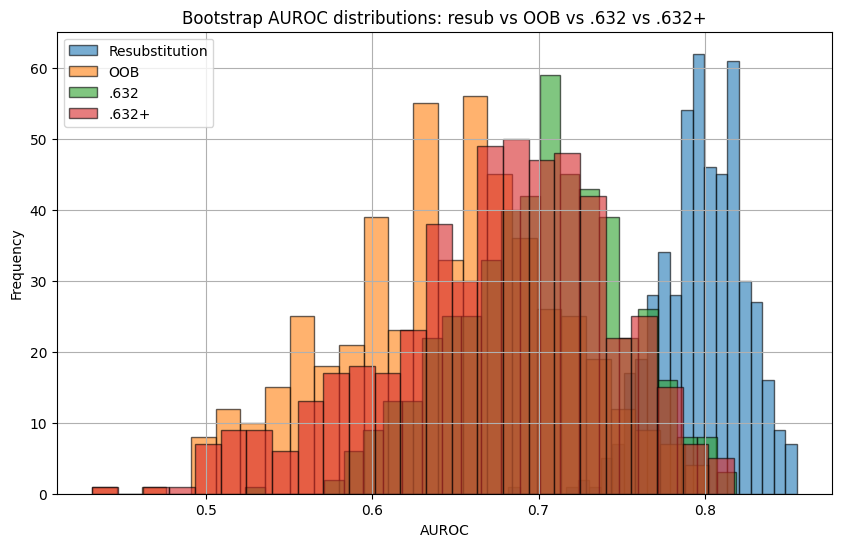


Compare to repeated-test AUROC:
  repeated-test mean: 0.7559 ± 0.0131
  bootstrap OOB mean : 0.6442 ± 0.0667
  bootstrap .632 mean: 0.7008 ± 0.0493
  bootstrap .632+ mean: 0.6726 ± 0.0697


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

def bootstrap_632plus_auroc(
    X, y,
    num_iterations=500,
    C=10.0, gamma=1.0, kernel="rbf",
    min_oob=10,
    random_seed=42,
    eps=1e-12
):
    """
    Compute .632 and .632+ bootstrap AUROC estimates.

    For each bootstrap iteration b:
      - sample indices with replacement (size n), stratified by y
      - train on bootstrap sample
      - compute:
          AUC_resub(b): AUROC on the original full dataset (X,y) using that model
          AUC_oob(b):   AUROC on OOB points (those not in bootstrap sample)
      - then:
          AUC_.632(b)   = 0.368*AUC_resub(b) + 0.632*AUC_oob(b)
          AUC_.632+(b)  = (1 - w(b))*AUC_resub(b) + w(b)*AUC_oob(b)
        where w(b) = 0.632 / (1 - 0.368*R(b))
        and R(b) is the "relative overfitting rate":
          R(b) = (AUC_resub(b) - AUC_oob(b)) / (AUC_resub(b) - AUC_noinfo)
        with AUC_noinfo = 0.5 for binary AUROC.

    Notes:
      - Uses decision_function (ranking) for AUROC.
      - Skips iterations with invalid OOB (too small or single-class).
      - Clips R into [0, 1] to keep weights well-behaved (standard practice).

    Returns
    -------
    out : dict of np.ndarray
      keys: "resub", "oob", "auc_632", "auc_632plus"
    summary : dict
      means/stds and counts
    """
    X = np.asarray(X)
    y = np.asarray(y)
    n = len(y)
    indices = np.arange(n)

    auc_noinfo = 0.5

    resub_list = []
    oob_list = []
    auc_632_list = []
    auc_632plus_list = []
    skipped = 0

    for b in range(num_iterations):
        boot_idx = resample(
            indices,
            replace=True,
            n_samples=n,
            stratify=y,
            random_state=random_seed + b
        )

        # OOB indices: those not selected at least once
        oob_mask = np.ones(n, dtype=bool)
        oob_mask[np.unique(boot_idx)] = False
        oob_idx = indices[oob_mask]

        # validity checks
        if len(oob_idx) < min_oob:
            skipped += 1
            continue
        if len(np.unique(y[oob_idx])) < 2:
            skipped += 1
            continue
        if len(np.unique(y[boot_idx])) < 2:
            skipped += 1
            continue

        model = SVC(C=C, kernel=kernel, gamma=gamma)
        model.fit(X[boot_idx], y[boot_idx])

        # Resubstitution AUROC: evaluate on full original dataset
        s_full = model.decision_function(X)
        auc_resub = roc_auc_score(y, s_full)

        # OOB AUROC: evaluate on OOB subset
        s_oob = model.decision_function(X[oob_idx])
        auc_oob = roc_auc_score(y[oob_idx], s_oob)

        # .632
        auc_632 = 0.368 * auc_resub + 0.632 * auc_oob

        # .632+ weight
        # R = (resub - oob) / (resub - noinfo)
        denom = (auc_resub - auc_noinfo)
        if abs(denom) < eps:
            # if resub is ~no-info, treat as no overfitting
            R = 0.0
        else:
            R = (auc_resub - auc_oob) / denom

        # clip R to [0,1] (standard stabilization)
        R = float(np.clip(R, 0.0, 1.0))

        # w = 0.632 / (1 - 0.368*R)
        w = 0.632 / (1.0 - 0.368 * R)

        # final .632+ estimate for this iteration
        auc_632plus = (1.0 - w) * auc_resub + w * auc_oob

        resub_list.append(auc_resub)
        oob_list.append(auc_oob)
        auc_632_list.append(auc_632)
        auc_632plus_list.append(auc_632plus)

    resub = np.asarray(resub_list)
    oob = np.asarray(oob_list)
    auc_632 = np.asarray(auc_632_list)
    auc_632plus = np.asarray(auc_632plus_list)

    out = {
        "resub": resub,
        "oob": oob,
        "auc_632": auc_632,
        "auc_632plus": auc_632plus
    }

    summary = {
        "kept": len(auc_632plus),
        "skipped": skipped,
        "mean_resub": float(np.mean(resub)) if len(resub) else np.nan,
        "std_resub": float(np.std(resub, ddof=1)) if len(resub) > 1 else np.nan,
        "mean_oob": float(np.mean(oob)) if len(oob) else np.nan,
        "std_oob": float(np.std(oob, ddof=1)) if len(oob) > 1 else np.nan,
        "mean_632": float(np.mean(auc_632)) if len(auc_632) else np.nan,
        "std_632": float(np.std(auc_632, ddof=1)) if len(auc_632) > 1 else np.nan,
        "mean_632plus": float(np.mean(auc_632plus)) if len(auc_632plus) else np.nan,
        "std_632plus": float(np.std(auc_632plus, ddof=1)) if len(auc_632plus) > 1 else np.nan,
    }

    return out, summary


def plot_bootstrap_distributions(out, bins=25):
    plt.figure(figsize=(10, 6))
    plt.hist(out["resub"], bins=bins, alpha=0.6, edgecolor="k", label="Resubstitution")
    plt.hist(out["oob"], bins=bins, alpha=0.6, edgecolor="k", label="OOB")
    plt.hist(out["auc_632"], bins=bins, alpha=0.6, edgecolor="k", label=".632")
    plt.hist(out["auc_632plus"], bins=bins, alpha=0.6, edgecolor="k", label=".632+")
    plt.title("Bootstrap AUROC distributions: resub vs OOB vs .632 vs .632+")
    plt.xlabel("AUROC")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()


# -----------------------------
# Drop-in usage (replace your old step 8/9/10)
# Assumes you already have X_train, y_train from your generator.
# -----------------------------
if __name__ == "__main__":
    # Example expects these exist in your script:
    # X_train, y_train = ...
    # (If not, uncomment and generate them using your generator)

    # from numpy.random import randn
    # generator = DataStreamGenerator(pos_ratio=0.2, d=2, random_seed=42)
    # X_train, y_train = generator.generate_batch(200)

    out, summary = bootstrap_632plus_auroc(
        X_train, y_train,
        num_iterations=500,
        C=10.0, gamma=1.0, kernel="rbf",
        min_oob=10,
        random_seed=42
    )

    print("Bootstrap .632+ summary:")
    for k, v in summary.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")

    # Step 9: plot histogram(s)
    plot_bootstrap_distributions(out, bins=25)

    # Step 10 "fix": report the .632+ estimate as your bootstrap-corrected performance
    # (Optionally compare to your repeated-test AUROCs if you have them)
    if "test_aurocs" in globals():
        print("\nCompare to repeated-test AUROC:")
        print(f"  repeated-test mean: {np.mean(test_aurocs):.4f} ± {np.std(test_aurocs, ddof=1):.4f}")
        print(f"  bootstrap OOB mean : {np.mean(out['oob']):.4f} ± {np.std(out['oob'], ddof=1):.4f}")
        print(f"  bootstrap .632 mean: {np.mean(out['auc_632']):.4f} ± {np.std(out['auc_632'], ddof=1):.4f}")
        print(f"  bootstrap .632+ mean: {np.mean(out['auc_632plus']):.4f} ± {np.std(out['auc_632plus'], ddof=1):.4f}")
